# 1. Setting up the environment

In [ ]:
!pip install pillow

In [ ]:
import torch
import torchvision
import warnings

warnings.filterwarnings('ignore')

In [ ]:
print(torch.cuda.is_available())

True


# 2. Preparing the Dataset

In [ ]:
import matplotlib.pyplot as plt

from torch.utils import data 
from torchvision import datasets, transforms

If you want the optimized model, you can upload the two files "ot_gan_critic.pt" and "ot_gan_gen.pt". Then replace the two "None" in the next cells by the content of each file.

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict()
args_dict = {'image_size': 32,
            'batch_size_train': 64,
            'z_dim': 100,
            'learning_rate': 0.0003,
            'beta1': 0.5,
            'beta2': 0.999,
            'g2c_ratio': 3,
            'n_epochs': 10,
            'epsilon': 1.,
            'niter': 100,
            'log_step': 2,
            'checkpoint_time': 1,
            'path_weights_generator': None,
            'path_weights_critic': None,
            'eval_dir': 'OTGAN_eval',
            'n_samples': 10
            }
args.update(args_dict)

In [ ]:
class DoubleBatchDataset(data.Dataset):
    """
    Extend Torch Dataset class to enable double batch streaming.
    """
    def __init__(self, dataset1, dataset2, transform=None):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.transform = transform

    def __len__(self):
        return self.dataset1.shape[0]

    def __getitem__(self, index):
        x, y = self.dataset1[index], self.dataset2[index]
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y


def MNIST_dataloader(args, double_batch=False):
    """
    Download, preprocess and load MNIST data.
    """
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize(args.image_size),
                                   transforms.ToTensor()
                                   ])
    
    mnist = datasets.MNIST('/content/OTGAN/MNIST', train=True, download=True)

    if double_batch:
        batch = mnist.data.unsqueeze(1)
        mnist = DoubleBatchDataset(batch, batch, transform)

    return data.DataLoader(mnist, batch_size=args.batch_size_train, shuffle=True)

In [ ]:
train_loader_X = MNIST_dataloader(args, double_batch=True)

samples = enumerate(train_loader_X)
_, (pair1, pair2) = next(samples)

# check shapes of samples from Double batch MNIST dataset
print(pair1.shape, pair2.shape)

# check range of pixel values 
print(pair1.min(), pair1.max())
print(pair2.min(), pair2.max())

torch.Size([64, 1, 32, 32]) torch.Size([64, 1, 32, 32])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


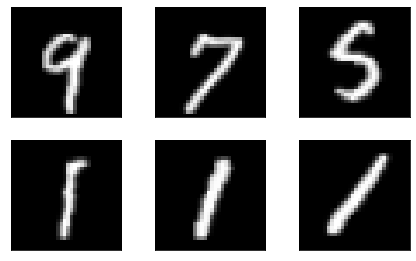

In [ ]:
fig_MNIST = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(pair1[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.show()

# 3. OT-GAN

In [ ]:
import os
import time
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

## 3.1. Helper functions

In [ ]:
def print_arguments(opts):
    """
    Print the values of all command-line arguments.
    opts: command-line arguments
    """
    print('=' * 80)
    print('Command line arguments'.center(80))
    print('=' * 80)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]))
    print('=' * 80)

def plot_samples(samples):
    n_row, n_col = samples.shape[0], int(samples.shape[0]/2)
    image  = make_grid(samples, n_row=1)
    np_img = image.numpy()
    plt.figure(figsize = (n_row, n_col))
    plt.xticks(())
    plt.yticks(())
    plt.imshow(np.transpose(np_img, (1,2,0)), interpolation='nearest')

## 3.2. Building the network

In [ ]:
class OTGANGenerator(nn.Module):
    """
    Generator architecture from Salimans et al (2018)
    """
    def __init__(self, input_size, kernel_size=5):
        super(OTGANGenerator, self).__init__()

        conv_padding_size = (kernel_size - 1) // 2

        self.linear   = nn.Linear(input_size, 2*512*8*8)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(512, 2*256, kernel_size, padding=conv_padding_size)
        self.conv2 = nn.Conv2d(256, 2*128, kernel_size, padding=conv_padding_size)
        self.conv3 = nn.Conv2d(128, 1, kernel_size, padding=conv_padding_size)
        self.activ_out = nn.Tanh()

    def forward(self, x):

        x = self.linear(x)                                          # batch_size x 65536
        # GLU activation function
        x, l = torch.split(x, x.shape[1]//2, 1)
        x *= torch.sigmoid(l)                                       # batch_size x 32768
        x = x.view((x.shape[0], 512, 8, 8))                         # batch_size x 512 x 8 x 8
        x = self.upsample(x)                                        # batch_size x 512 x 16 x 16
        x = self.conv1(x)                                           # batch_size x 512 x 16 x 16
        x, l = torch.split(x, x.shape[1]//2, 1)
        x *= torch.sigmoid(l)                                       # batch_size x 256 x 16 x 16
        x = self.upsample(x)                                        # batch_size x 256 x 32 x 32
        x = self.conv2(x)                                           # batch_size x 256 x 32 x 32
        x, l = torch.split(x, x.shape[1]//2, 1)
        x *= torch.sigmoid(l)                                       # batch_size x 128 x 32 x 32
        x = self.activ_out(self.conv3(x))                           # batch_size x 1 x 32 x 32

        return x                                                    # batch_size x 1 x 32 x 32


class OTGANCritic(nn.Module):
    """
    Critic architecture from Salimans et al (2018)
    """
    def __init__(self, kernel_size=5):
        super(OTGANCritic, self).__init__()

        conv1_channels = 64
        conv_padding_size = (kernel_size - 1) // 2

        self.conv1 = nn.Conv2d(1, conv1_channels, kernel_size, padding=conv_padding_size)
        self.conv2 = nn.Conv2d(conv1_channels*2, conv1_channels*2, kernel_size, stride=2, padding=conv_padding_size)
        self.conv3 = nn.Conv2d(conv1_channels*4, conv1_channels*4, kernel_size, stride=2, padding=conv_padding_size)

    def forward(self, x):
        x = self.conv1(x)                                           # batch_size x 64 x 32 x 32
        # CReLU : https://github.com/pytorch/pytorch/issues/1327
        x = torch.cat((F.relu(x), F.relu(-x)), 1)                   # batch_size x 128 x 32 x 32
        x = self.conv2(x)                                           # batch_size x 128 x 16 x 16
        x = torch.cat((F.relu(x), F.relu(-x)), 1)                   # batch_size x 256 x 16 x 16
        x = self.conv3(x)                                           # batch_size x 256 x 8 x 8
        x = torch.cat((F.relu(x), F.relu(-x)), 1)                   # batch_size x 512 x 8 x 8
        x = nn.Flatten()(x)                                         # batch_size x 32768
        x = F.normalize(x, dim=1, p=2)                              # batch_size x 32768

        return x                                                    # batch_size x 32768

In [ ]:
class OTGAN():
    """
    OTGAN implementation as described in Salimans et al (2018)
    """
    def __init__(self, dataloader, generator, critic, args):

        self.dataloader = dataloader

        self.z_dim = args.z_dim
        self.lr    = args.learning_rate
        self.g2c_ratio = args.g2c_ratio

        self.generator = generator
        self.critic    = critic

    def uniform_sample(self, size):
        """
        Uniform sampling from [-1,1]
        """
        return -2 * torch.rand(size) + 1

    def sample_data(self, n_sample):
        """
        Generate synthetic images from random uniform noise.
        """
        u = self.uniform_sample((n_sample, self.z_dim)).cuda()
        samples = self.generator(u)
        samples = samples.detach().cpu()
        return samples

    def cost(self, batch_1, batch_2):
        """
        Cosine distance between batch embeddings.
        """
        dot = batch_1 @ batch_2.t()
        return 1 - dot

    def sinkhorn(self, a, b, C, args):
        """
        Compute OT plans using Sinkhorn algorithm.
        """
        u = torch.ones_like(a).cuda()
        v = torch.ones_like(b).cuda()
        with torch.no_grad():
            K = torch.exp(- C / args.epsilon)
            for i in range(args.niter):
                u = a / (torch.matmul(K,v) + 1e-8)
                v = b / (torch.matmul(K.T,u) + 1e-8)
        M = torch.matmul(torch.diag(u), torch.matmul(K, torch.diag(v)))
        return M

    def train(self, args):
        c_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr, betas=(args.beta1, args.beta2))
        g_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(args.beta1, args.beta2))
        for epoch in range(args.n_epochs):
            t0 = time.time()
            for i, (real_1, real_2) in enumerate(self.dataloader):
                batch_size = real_1.shape[0]
                
                self.critic.zero_grad()
                self.generator.zero_grad()
    
                real_1 = real_1.type(torch.FloatTensor).cuda()
                real_2 = real_2.type(torch.FloatTensor).cuda()
                
                z1 = self.uniform_sample((batch_size, self.z_dim)).cuda()
                z2 = self.uniform_sample((batch_size, self.z_dim)).cuda()
                fake_1 = self.generator(z1)
                fake_2 = self.generator(z2)
                
                critic_real_1 = self.critic(real_1)
                critic_real_2 = self.critic(real_2)
                critic_fake_1 = self.critic(fake_1)
                critic_fake_2 = self.critic(fake_2)

                # Computing costs
                costs = torch.zeros((4, 4, batch_size, batch_size)).cuda()
                costs[0,1] = self.cost(critic_real_1, critic_real_2)
                costs[0,2] = self.cost(critic_real_1, critic_fake_1)
                costs[0,3] = self.cost(critic_real_1, critic_fake_2)
                costs[1,2] = self.cost(critic_real_2, critic_fake_1)
                costs[1,3] = self.cost(critic_real_2, critic_fake_2)
                costs[2,3] = self.cost(critic_fake_1, critic_fake_2)

                # Computing optimal plans for all costs
                a = (torch.ones(batch_size) / batch_size).cuda()
                b = (torch.ones(batch_size) / batch_size).cuda()
                plans = torch.zeros((4,4, batch_size, batch_size)).cuda()
                plans[0,1] = self.sinkhorn(a, b, costs[0,1], args)
                plans[0,2] = self.sinkhorn(a, b, costs[0,2], args)
                plans[0,3] = self.sinkhorn(a, b, costs[0,3], args)
                plans[1,2] = self.sinkhorn(a, b, costs[1,2], args)
                plans[1,3] = self.sinkhorn(a, b, costs[1,3], args)
                plans[2,3] = self.sinkhorn(a, b, costs[2,3], args) 

                # Computing losses
                losses = torch.zeros((4,4)).cuda()
                losses[0,1] = torch.sum(plans[0,1] * costs[0,1])
                losses[0,2] = torch.sum(plans[0,2] * costs[0,2])
                losses[0,3] = torch.sum(plans[0,3] * costs[0,3])
                losses[1,2] = torch.sum(plans[1,2] * costs[1,2])
                losses[1,3] = torch.sum(plans[1,3] * costs[1,3])
                losses[2,3] = torch.sum(plans[2,3] * costs[2,3])    
                
                loss = (losses[0,2] + losses[0,3] + losses[1,2] + losses[1,3] - 2 * losses[0,1] - 2 * losses[2,3])                            
                loss.backward()

                if i+1 % self.g2c_ratio == 0:
                    # Update critic once every 'g2c_ratio' updates
                    c_optimizer.step()
                else:
                    g_optimizer.step()
   
            if epoch % args.log_step == 0 or epoch+1 == args.n_epochs:
                train_loss = loss.detach().cpu().numpy()
                print("Epoch %s: loss = %s;  time = %s" %(epoch, train_loss, time.time() - t0))
                
            if epoch % args.log_step == 0 or epoch+1 == args.n_epochs:
                samples = self.sample_data(args.n_samples)
                if not os.path.isdir(args.eval_dir):
                    os.makedirs(args.eval_dir)
                save_image(samples, args.eval_dir+'/eval_sample.png', nrow=1)

            if args.checkpoint_time:
                torch.save(self.generator.state_dict(), '/content/ot_gan_gen.pt')
                torch.save(self.critic.state_dict(), '/content/ot_gan_critic.pt')

## 3.3. Training and Evaluation functions

In [ ]:
def train(args, resume_training=False):
    # Get MNIST data as Torch dataloader
    mnist_dataloader = MNIST_dataloader(args, train=True, double_batch=True)
    otgan_generator = OTGANGenerator(input_size=args.z_dim).cuda()
    otgan_critic    = OTGANCritic().cuda()
    if resume_training:
        # Load pretrained weights
        try:
            otgan_generator.load_state_dict(torch.load(args.path_weights_generator))
            otgan_critic.load_state_dict(torch.load(args.path_weights_critic))
        except:
            print('Please define checkpoints path in command_line arguments.')

    otgan = OTGAN(mnist_dataloader, otgan_generator, otgan_critic, args)
    try:
        print('Start Training ...')
        otgan.train(args)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return otgan
    
    return otgan

def test(args):
    # Load previously trained model weights
    otgan_generator = OTGANGenerator(input_size=args.z_dim).cuda()
    otgan_generator.load_state_dict(torch.load(args.path_weights_generator))
    otgan = OTGAN(dataloader=None, generator=otgan_generator, critic=None, args=args)
    # Sample data produced by the OT-GAN generator
    samples = otgan.sample_data(args.n_samples)
    plot_samples(samples)

## 3.4. Run OT-GAN

In [ ]:
seed = 11
# Set random seed manually for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
# Set and print command line arguments
args.update(args_dict)
print_arguments(args)

                             Command line arguments                             
                    image_size: 32                            
              batch_size_train: 64                            
               batch_size_test: 1000                          
                         z_dim: 100                           
                 learning_rate: 0.0003                        
                         beta1: 0.5                           
                         beta2: 0.999                         
                      n_epochs: 10                            
                       epsilon: 1.0                           
                         niter: 100                           
                      log_step: 2                             
               checkpoint_time: 1                             
        path_weights_generator: ot_gan_gen.pt                 
                      eval_dir: OTGAN_eval                    
                     n_samples: 10   

### Train OT-GAN

The training takes more than 1 hour because of the double optimization problem. If you want to run the training cells, delete the "#" before the line "otgan = train(args, resume_training)"

In [ ]:
#resume_training = True 
#otgan = train(args, resume_training)

Start Training ...
Epoch 0: loss = 0.035706818;  time = 362.2677707672119
Epoch 2: loss = 0.03380239;  time = 371.6966679096222
Epoch 4: loss = 0.029173732;  time = 371.093341588974
Epoch 6: loss = 0.01780963;  time = 371.3102023601532
Epoch 8: loss = 0.012520701;  time = 371.5137104988098
Epoch 9: loss = 0.019110113;  time = 371.76067066192627


### Test OT-GAN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                             Command line arguments                             
                    image_size: 32                            
              batch_size_train: 64                            
               batch_size_test: 1000                          
                         z_dim: 100                           
                 learning_rate: 0.0003                        
                         beta1: 0.5                           
                         beta2: 0.999                         
                      n_epochs: 10                            
                       epsilon: 1.0                           
                         niter: 100                           
                      log_step: 2                             
               checkpoint_time: 1                             
        path_weights_generator: /content/ot_gan_gen.pt        
                      eval_dir: OTGAN_eval                    
                     n_samples: 10   

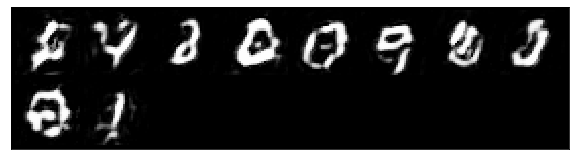

In [ ]:
# Set and print command line arguments
args_dict['path_weights_generator'] = '/content/ot_gan_gen.pt'
args.update(args_dict)
print_arguments(args)
# Test OT-GAN
test(args)